################ IMPORTING THE REQUIRED LIBRARIES

In [40]:
import librosa
import soundfile
import os, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn import preprocessing 
from sklearn.preprocessing import MinMaxScaler
from keras.utils import np_utils
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout,Flatten,BatchNormalization
from keras.optimizers import SGD
from keras.layers.convolutional import Conv1D, MaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping


############## EMOTIONS INCLUDED IN THE DATASET

In [41]:
emotions={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}

############## EXTRACTING FEATURES FROM THE AUDIO SIGNAL USING LIBROSA

In [42]:

def extract_feature(file_name, mfcc, chroma,spectral_centroid,spectral_bandwidth,spectral_rolloff,
                    spectral_contrast,rms,spectral_flatness):
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32")
        sample_rate=sound_file.samplerate
        if chroma:
            stft=np.abs(librosa.stft(X))
        result=np.array([])
        if mfcc:
            mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
            result=np.hstack((result, mfccs))
            
            
        if chroma:
            chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
            result=np.hstack((result, chroma))             
           
            
        if spectral_centroid:
            spectral_centroid=np.mean(librosa.feature.spectral_centroid(y=X, sr=sample_rate))
            result=np.hstack((result, spectral_centroid)) 
        
        if spectral_bandwidth:
           spectral_bandwidth=np.mean(librosa.feature.spectral_bandwidth(y=X, sr=sample_rate).T)
#           print(spectral_bandwidth)
           result=np.hstack((result, spectral_bandwidth)) 
           
        if spectral_rolloff:
           spectral_rolloff=np.mean(librosa.feature.spectral_rolloff(y=X, sr=sample_rate).T)
#           print(spectral_rolloff)
           result=np.hstack((result, spectral_rolloff))
        
        if spectral_contrast:
           spectral_contrast=np.mean(librosa.feature.spectral_contrast(y=X, sr=sample_rate))
           result=np.hstack((result, spectral_contrast))
           
        if rms:
           rms=np.mean(librosa.feature.rms(y=X).T,axis=0)
           result=np.hstack((result, rms))
           
        if spectral_flatness:
           spectral_flatness=np.mean(librosa.feature.spectral_flatness(y=X))
           result=np.hstack((result, spectral_flatness))
        
        return result

############## LOADING THE DATASET AND EXTRACTING ALL THE FEATURES FROM IT 

In [43]:
def load_data():
    x,y=[],[]
    for file in glob.glob("F:\\speech_project\\Actor_*\\*.wav"):
        file_name=os.path.basename(file)
        emotion=emotions[file_name.split("-")[2]]
        feature=extract_feature(file, mfcc=True, chroma=True,spectral_centroid=True,spectral_bandwidth=True,
                                spectral_rolloff=True,spectral_contrast=True,rms=True,spectral_flatness=True)
        x.append(feature)
        y.append(emotion)
        
        
    # Create scaler: scaler
    scaler = MinMaxScaler()
    X=scaler.fit_transform(x)
    X=pd.DataFrame(X)
    ############  n_components=40
    pca = PCA(n_components=40)
    principalComponents = pca.fit_transform(X)
    return principalComponents,y

############## SHUFFLING OF OBS AND RESETTING THE OBS INDEXES

In [ ]:
X,y=load_data()
X=pd.DataFrame(X)
y=pd.DataFrame(y)
data=pd.concat([X,y],axis="columns")
data=data.sample(frac=1).reset_index(drop=True)
X=data.iloc[:,0:58]
y=data.iloc[:,58]

############## LABEL ENCODING THE RESPONSE VARIABLES

In [ ]:
le = preprocessing.LabelEncoder()
y=le.fit_transform(y)

############## SPLITTING THE DATA INTO TRAIN(95%) AND TEST(5%)

In [18]:
x_train,x_test,y_train,y_test=train_test_split(X, y, test_size=0.05, random_state=42)
print((x_train.shape[0], x_test.shape[0]))
print(f'Features extracted: {x_train.shape[1]}')

(1311, 40) (69, 40)


################ Plot to find n_components

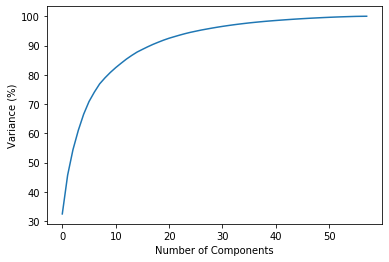

In [9]:

pca = PCA()
principalComponents = pca.fit_transform(x_train)
#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_ * 100))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.show()
cumsum=np.cumsum(pca.explained_variance_ratio_ * 100)


############## RESHAPING PREDICTORS

In [19]:
x_traincnn = np.expand_dims(x_train, axis=2)
x_testcnn = np.expand_dims(x_test, axis=2)
print(x_traincnn.shape)
print(x_testcnn.shape)

(1311, 40, 1)
(69, 40, 1)


############## LABEL ENCODING THE RESPONSE VARIABLES AND CREATING DUMMIES

In [20]:
lb = LabelEncoder()
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
print(y_train.shape)
print(y_test.shape)

Features extracted: 40
(1311, 8)
(69, 8)


############ 1D CNN #############

In [21]:
model = Sequential()
model.add(Conv1D(250, 3, padding='same',input_shape=(x_traincnn.shape[1],1)))
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Conv1D(205, 5, padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.35))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=(8),strides=2))
model.add(Conv1D(205, 7, padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.4))
model.add(BatchNormalization())
model.add(Conv1D(205, 7, padding='same'))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(8))
model.add(Activation('softmax'))
opt =SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False)

#################### TRAINING THE MODEL

In [22]:
model.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'])
model.fit(x_traincnn,y_train,validation_data=(x_testcnn,y_test),verbose=2,epochs=100)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 1311 samples, validate on 69 samples
Epoch 1/100





 - 5s - loss: 2.2560 - acc: 0.1640 - val_loss: 2.1664 - val_acc: 0.1594
Epoch 2/100
 - 3s - loss: 2.1030 - acc: 0.2052 - val_loss: 2.2937 - val_acc: 0.1304
Epoch 3/100
 - 4s - loss: 2.1027 - acc: 0.1899 - val_loss: 2.7394 - val_acc: 0.1304
Epoch 4/100
 - 3s - loss: 2.0372 - acc: 0.2227 - val_loss: 2.7759 - val_acc: 0.1884
Epoch 5/100
 - 4s - loss: 1.9709 - acc: 0.2479 - val_loss: 2.5662 - val_acc: 0.1159
Epoch 6/100
 - 3s - loss: 1.9211 - acc: 0.2784 - val_loss: 2.3546 - val_acc: 0.1449
Epoch 7/100
 - 4s - loss: 1.9270 - acc: 0.2662 - val_loss: 2.8714 - val_acc: 0.1884
Epoch 8/100
 - 3s - loss: 1.8500 - acc: 0.2921 - val_loss: 2.5328 - val_acc: 0.1159
Epoch 9/100
 - 3s - loss: 1.8310 - acc: 0.2960 - val_loss: 2.6847 - val_acc: 0.1449
Epoch 10/100
 - 3s - loss: 1.8283 - acc: 0.3112 - val_loss: 2.7029 - val_acc: 0.1594
Epoch 11/

Epoch 71/100
 - 4s - loss: 0.8104 - acc: 0.7063 - val_loss: 1.7855 - val_acc: 0.4493
Epoch 72/100
 - 3s - loss: 0.7684 - acc: 0.7323 - val_loss: 2.0140 - val_acc: 0.4058
Epoch 73/100
 - 4s - loss: 0.6956 - acc: 0.7551 - val_loss: 1.7005 - val_acc: 0.4058
Epoch 74/100
 - 4s - loss: 0.7346 - acc: 0.7201 - val_loss: 1.6653 - val_acc: 0.5217
Epoch 75/100
 - 4s - loss: 0.7159 - acc: 0.7429 - val_loss: 1.7120 - val_acc: 0.5072
Epoch 76/100
 - 3s - loss: 0.7375 - acc: 0.7346 - val_loss: 1.7753 - val_acc: 0.5217
Epoch 77/100
 - 3s - loss: 0.7101 - acc: 0.7437 - val_loss: 1.6439 - val_acc: 0.4928
Epoch 78/100
 - 4s - loss: 0.6959 - acc: 0.7506 - val_loss: 1.8019 - val_acc: 0.4638
Epoch 79/100
 - 4s - loss: 0.7117 - acc: 0.7429 - val_loss: 1.8810 - val_acc: 0.4058
Epoch 80/100
 - 4s - loss: 0.6627 - acc: 0.7689 - val_loss: 1.7263 - val_acc: 0.4928
Epoch 81/100
 - 3s - loss: 0.6859 - acc: 0.7490 - val_loss: 1.5887 - val_acc: 0.5072
Epoch 82/100
 - 3s - loss: 0.6680 - acc: 0.7666 - val_loss: 1.690

#################### PREDICTION ON TEST SET

In [23]:
y_pred_prob = model.predict(x_testcnn)
y_pred_prob.shape

(69, 8)

In [24]:
loss, acc = model.evaluate(x_testcnn, y_test,verbose=0)

print('Test loss = {:.4f} '.format(loss))
print('Test acc = {:.4f} '.format(acc))

Test loss = 1.6527 
Test acc = 0.5507 


############# SAVING THE MODEL

In [ ]:
import pickle
pickle.dump(model, open("C:\\Users\\dbda\\Desktop\\project\\PCA_CNN.pkl", 'wb'))
print("Model Saved!!")

#################### Prediction on unseen data

In [35]:

def load_test_data():
    x_test,y_test=[],[]
    
    #file="F:\\speech_project\\UnSeenSet\\*.wav"
    for file in glob.glob("F:\\speech_project\\UnSeenSet\\*.wav"):
        file_name=os.path.basename(file)
        emotion=emotions[file_name.split("-")[2]]
        feature=extract_feature(file, mfcc=True, chroma=True,spectral_centroid=True,spectral_bandwidth=True,
                                spectral_rolloff=True,spectral_contrast=True,rms=True,spectral_flatness=True)
        x_test.append(feature)
        y_test.append(emotion)
    # Create scaler: scaler
    scaler = MinMaxScaler()
    x_test=scaler.fit_transform(x_test)
    x_test=pd.DataFrame(x_test)
    ############  n_components=40
    pca = PCA(n_components=20)
    x_test = pca.fit_transform(x_test)
    return x_test,y_test

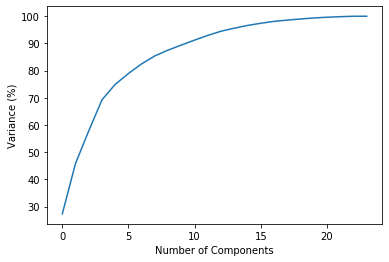

In [34]:

pca = PCA()
principalComponents = pca.fit_transform(X_test_data)
#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_ * 100))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.show()
cumsum=np.cumsum(pca.explained_variance_ratio_ * 100)

In [39]:
X_test_data,y_test_data=load_test_data()
print(len(y_test_data))
print(X_test_data.shape)

24
(24, 20)


In [37]:
############## RESHAPING PREDICTORS

X_test_data = np.expand_dims(X_test_data, axis=2)
print(X_test_data.shape)

(24, 20, 1)


########### LOADING SAVED MODEL

In [ ]:
import pickle
loaded_model = pickle.load(open("C:\\Users\\dbda\\Desktop\\project\\PCA_CNN.pkl", 'rb'))
result = loaded_model.predict_classes(X_test_data)
print(result)

In [ ]:
print(le.inverse_transform(result))